# Тематическое моделирование при помощи LDA


1. Идея там такая. Нужно потом взять категорию два и по ней построить тематическую модель, т.е. выделить темы, к которым относятся эти твиты. Например, алгоритмом LDA (latent Dirichle allocation).
Дальше хочется на временной оси отметить активность каждой выделенной темы (в штуках твитов за день/неделю/месяц).
Затем ретроспективно связать пики активности с какими-то событиями, произошедшими в мире.

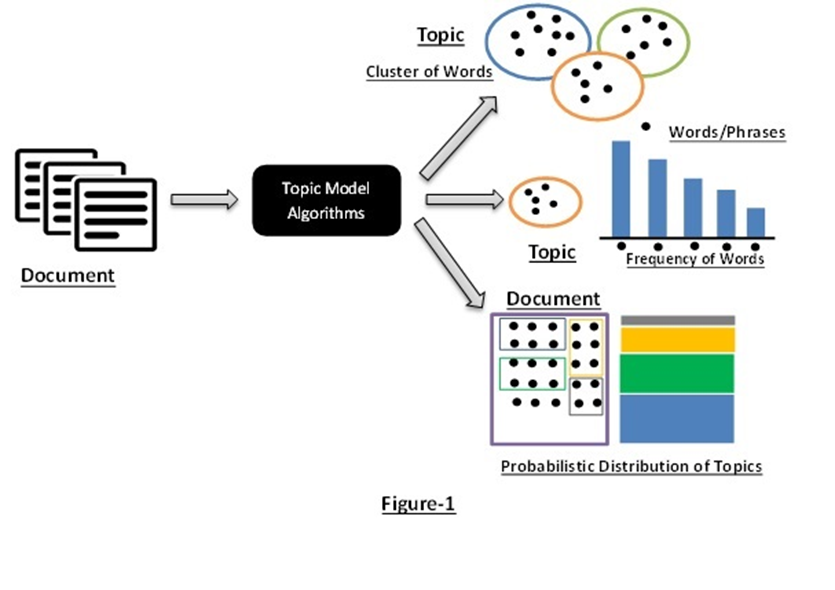

Трансформеры для лучшей классификации
https://explosion.ai/blog/spacy-transformers

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')
# Run in terminal or command prompt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PEKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install Pyro4

In [ ]:
!pip install scipy

In [ ]:
from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\PEKA\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [ ]:
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')
#stop_words.extend(['\n','\n ','\n  ', '\n   ' '\n\n', "\n\n ", 
                              #  "  ", "|", '$', '\\n', 'toxic', 'toxicity'])
    
text_file = open("stop_words_english.txt", "r", encoding='utf-8')
ignorewords = text_file.readlines()
text_file.close()

stop_words = [line.rstrip() for line in ignorewords]


update = ['\n','\n ','\n  ', '\n   ' '\n\n', "\n\n ", 
                                "  ", "|", '$', '\\n', 'toxic', 'toxicity']
for i in range(len(update)):
    stop_words.append(update[i])

In [ ]:
df = pd.read_pickle('FinalEN')

In [ ]:
# Convert to list
data = df[0].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
#print(data_words[:1])

In [ ]:
# Build the bigram and trigram models
#bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
#bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

['uk', 'home', 'daily', 'mail', 'online', 'home', 'news', 'sport', 'tv', 'showbiz', 'australia', 'femail', 'health', 'science', 'money', 'video', 'travel', 'best', 'buys', 'discounts', 'argos_ao', 'com', 'river', 'island', 'groupon_debenhams_wayfair', 'very', 'ebay_boohoo_nike_currys', 'virgin', 'media', 'asos_tui', 'my', 'profile', 'logout_login', 'latest', 'headlines', 'world', 'news', 'you', 'mag_books_promos_rewards', 'mail', 'shop_property_motoring', 'columnists', 'covid', 'my', 'profile', 'logout_login', 'privacy', 'policy', 'feedback_tuesday_apr', 'th', 'pm', 'pm', 'day', 'forecast', 'home', 'last', 'updated_bst', 'april', 'advertisement', 'show', 'ad', 'boris', 'insists', 'lockdown', 'will', 'end', 'on', 'time', 'despite', 'sage', 'doomsday', 'third', 'wave', 'scenarios_tory', 'fury', 'grows', 'at', 'never', 'ending', 'restrictions', 'despite', 'the', 'most', 'likely', 'projection', 'that', 'deaths', 'will', 'stay', 'in', 'double_figures', 'the', 'prime', 'minister', 'said', 'h

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized[:1])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
#print(corpus[:1])

In [ ]:
print(len(id2word))

202752


In [ ]:
#сделать здесь lda.multicore
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=13, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.861496141046743

Coherence Score:  0.5356197891861012


In [ ]:
lda_model.show_topics()

[(7,
  '0.160*"cancer" + 0.045*"abortion" + 0.036*"baby" + 0.034*"tumor" + 0.034*"woman" + 0.031*"breast" + 0.028*"paris" + 0.025*"birth" + 0.025*"pregnant" + 0.025*"radiation"'),
 (10,
  '0.080*"food" + 0.032*"eat" + 0.022*"dog" + 0.021*"farmer" + 0.018*"cat" + 0.017*"farm" + 0.017*"animal" + 0.012*"crop" + 0.011*"meat" + 0.010*"fruit"'),
 (3,
  '0.052*"police" + 0.020*"officer" + 0.019*"gun" + 0.019*"kill" + 0.019*"crime" + 0.017*"drug" + 0.015*"murder" + 0.014*"arrest" + 0.014*"law" + 0.014*"death"'),
 (2,
  '0.020*"family" + 0.013*"war" + 0.013*"russian" + 0.013*"military" + 0.010*"russia" + 0.009*"harry" + 0.009*"prince" + 0.009*"hotel" + 0.008*"tribe" + 0.008*"weapon"'),
 (9,
  '0.029*"product" + 0.015*"plastic" + 0.011*"chemical" + 0.009*"skin" + 0.009*"hand" + 0.009*"buy" + 0.008*"material" + 0.008*"design" + 0.008*"brand" + 0.007*"robot"'),
 (12,
  '0.047*"trump" + 0.019*"president" + 0.011*"election" + 0.011*"political" + 0.010*"party" + 0.010*"republican" + 0.010*"house" + 0

In [ ]:
pyLDAvis.enable_notebook()
data = gensimvis.prepare(lda_model, corpus, id2word)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.184400  0.022499       1        1  17.050620
4      0.143270 -0.044433       2        1  16.589143
8      0.169083 -0.039390       3        1  11.813664
12     0.145744  0.137730       4        1  11.245758
6      0.090218  0.078056       5        1  10.302191
1      0.004420 -0.085090       6        1   6.865468
5      0.077399 -0.055423       7        1   6.850623
0      0.064922 -0.082945       8        1   6.337193
2     -0.026817  0.209868       9        1   5.544067
9     -0.061909 -0.263480      10        1   3.313089
3     -0.139732  0.212390      11        1   2.198298
10    -0.269793 -0.210208      12        1   1.472605
7     -0.381205  0.120424      13        1   0.417280, topic_info=           Term          Freq         Total Category  logprob  loglift
5014      trump  93606.000000  93606.000000  Default  30.0000  30.0000
151       woman  48940.000000  48940.000000  Default  29.0000  29.0000
1058       food  24490.000000  24490.000000  Default  28.0000  28.0000
17       cancer  16399.000000  16399.000000  Default  27.0000  27.0000
1022    company  45093.000000  45093.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
225      infant    581.755156   1039.689859  Topic13  -4.8485   4.8985
151       woman   2489.456644  48940.749550  Topic13  -3.3947   2.5006
2515     clinic    559.232503   2008.563640  Topic13  -4.8880   4.2006
130     surgery    550.984024   1926.748260  Topic13  -4.9028   4.2273
3184  procedure    420.509724   1458.797946  Topic13  -5.1731   4.2353

[814 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
15065     13  0.999789    abortion
9819       2  0.999184      abuser
10267      2  0.999326     abusive
10930      7  0.999527        acre
2997      13  0.997958  acrylamide
...      ...       ...         ...
309        5  0.063100       young
309        6  0.046822       young
309        7  0.009916       young
309       11  0.005780       young
5843       5  0.999922     youtube

[1852 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 5, 9, 13, 7, 2, 6, 1, 3, 10, 4, 11, 8])

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=20, step=1)

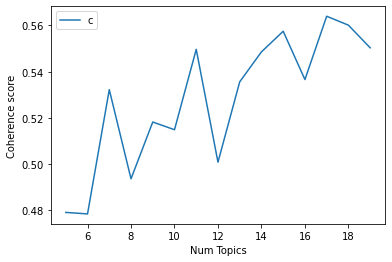

In [ ]:
limit=20; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4792
Num Topics = 6  has Coherence Value of 0.4785
Num Topics = 7  has Coherence Value of 0.5322
Num Topics = 8  has Coherence Value of 0.4937
Num Topics = 9  has Coherence Value of 0.5183
Num Topics = 10  has Coherence Value of 0.5149
Num Topics = 11  has Coherence Value of 0.5497
Num Topics = 12  has Coherence Value of 0.5009
Num Topics = 13  has Coherence Value of 0.5356
Num Topics = 14  has Coherence Value of 0.5486
Num Topics = 15  has Coherence Value of 0.5575
Num Topics = 16  has Coherence Value of 0.5366
Num Topics = 17  has Coherence Value of 0.564
Num Topics = 18  has Coherence Value of 0.5601
Num Topics = 19  has Coherence Value of 0.5503


In [ ]:
import os
from gensim.models.wrappers import LdaMallet

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})
mallet_path = r'C:/mallet-2.0.8/bin/mallet.bat' # update this path

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=20, step=1)

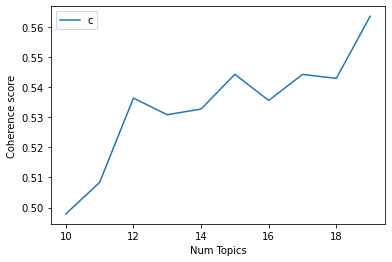

In [ ]:
limit=20; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.4979
Num Topics = 11  has Coherence Value of 0.5083
Num Topics = 12  has Coherence Value of 0.5364
Num Topics = 13  has Coherence Value of 0.5309
Num Topics = 14  has Coherence Value of 0.5328
Num Topics = 15  has Coherence Value of 0.5443
Num Topics = 16  has Coherence Value of 0.5356
Num Topics = 17  has Coherence Value of 0.5443
Num Topics = 18  has Coherence Value of 0.543
Num Topics = 19  has Coherence Value of 0.5637


In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=19, id2word=id2word)

In [ ]:
pprint(ldamallet.show_topics(formatted=False, num_topics = 19))
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('video', 0.024023994335082816),
   ('watch', 0.021761240547658094),
   ('volcano', 0.010436349390934897),
   ('lava', 0.008090796857602223),
   ('hawaii', 0.007440764912115928),
   ('eruption', 0.007062609445730365),
   ('island', 0.006295176293359664),
   ('hit', 0.005739065313380895),
   ('flight', 0.005443708592903282),
   ('people', 0.005430114768948246)]),
 (1,
  [('school', 0.025962018990504748),
   ('work', 0.015379310344827587),
   ('student', 0.012600699650174912),
   ('people', 0.009152423788105947),
   ('child', 0.009074462768615692),
   ('community', 0.00809895052473763),
   ('education', 0.0070664667666166915),
   ('black', 0.006951524237881059),
   ('teacher', 0.006508745627186407),
   ('high', 0.006064967516241879)]),
 (2,
  [('prince', 0.02015412066413726),
   ('royal', 0.014404048300607854),
   ('philip', 0.013105795870090496),
   ('brexit', 0.013013732296291788),
   ('harry', 0.010305658867009487),
   ('meghan', 0.009630005859300333),
   ('labour', 0.00948878

In [ ]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = gensim.models.ldamulticore.LdaMulticore(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(ldamallet)

In [ ]:
pyLDAvis.enable_notebook()
data = gensimvis.prepare(optimal_model, corpus, id2word)
data

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.154207 -0.102564       1        1  7.558520
2      0.043353  0.131654       2        1  7.283609
14     0.114130 -0.064729       3        1  6.594090
13     0.028887  0.187454       4        1  6.211610
8     -0.176187 -0.087148       5        1  6.007328
16     0.220440 -0.051746       6        1  5.881982
1     -0.054040  0.004350       7        1  5.694625
3     -0.226173  0.014645       8        1  5.602774
10     0.112467  0.128454       9        1  5.486000
11     0.049632  0.103651      10        1  5.314658
17    -0.105895  0.042773      11        1  5.023722
0     -0.095784  0.047777      12        1  4.676575
6      0.011043 -0.024839      13        1  4.659122
7      0.240093 -0.069418      14        1  4.554606
15    -0.186211  0.042165      15        1  4.296071
12    -0.087840  0.204045      16        1  4.101902
9     -0.099168 -0.247935      17        1  3.941997
4     -0.063431 -0.274477      18        1  3.823275
5      0.120478  0.015888      19        1  3.287533, topic_info=         Term          Freq         Total Category  logprob  loglift
5014    trump  38181.000000  38181.000000  Default  30.0000  30.0000
151     woman  49234.000000  49234.000000  Default  29.0000  29.0000
115    school  28173.000000  28173.000000  Default  28.0000  28.0000
10241  prince  26515.000000  26515.000000  Default  27.0000  27.0000
417      feel  36930.000000  36930.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
66      image   2585.504626  27494.271523  Topic19  -5.4210   1.0510
625      news   2518.728106  24038.784882  Topic19  -5.4472   1.1591
281      sign   2368.480665  17229.448073  Topic19  -5.5087   1.4307
304      week   2447.777850  34527.293712  Topic19  -5.4757   0.7685
58      getty   2281.879849  12912.015348  Topic19  -5.5459   1.6819

[1966 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1261       5  1.001339     abdominal
3507      15  0.970335         abita
15065      1  0.107337      abortion
15065      4  0.892480      abortion
2421       1  0.058963         abuse
...      ...       ...           ...
5194      14  0.990294     zellweger
14257      6  1.002051  zhongnanshan
13030     18  1.001204        zodiac
5506       1  0.993980          zola
17602     13  1.000272    zuckerberg

[5576 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 3, 15, 14, 9, 17, 2, 4, 11, 12, 18, 1, 7, 8, 16, 13, 10, 5, 6])

In [ ]:
pyLDAvis.save_html(data, 'ENtopics 0.5475621956806059.html')